In [1]:
! pip install pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow==2.15 pyarrow

In [2]:
! pip freeze > requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    accuracy_score
)

from xgboost import XGBRegressor, XGBClassifier
import tensorflow as tf

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("images", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print("Setup complete.")
print("TensorFlow version:", tf.__version__)
print("XGBoost imported:", XGBRegressor.__name__, "/", XGBClassifier.__name__)

Setup complete.
TensorFlow version: 2.15.0
XGBoost imported: XGBRegressor / XGBClassifier


In [4]:
from IPython.display import display

def load_panel(city: str, date_str: str) -> pd.DataFrame:
    """
    Load listings.csv and calendar.csv for a given city + date,
    merge them, clean key fields, and add time-based features.

    Parameters
    ----------
    city : str
        City folder name, e.g. "austin", "chicago", "dc", "santacruz".
    date_str : str
        Snapshot date string, e.g. "2025-03-06".

    Returns
    -------
    df : pd.DataFrame
        Night-level panel dataset for that city/date.
    """
    base_path = f"data/raw/{city}/{date_str}"
    listings_path = os.path.join(base_path, "listings.csv")
    calendar_path = os.path.join(base_path, "calendar.csv")

    print(f"\n=== Loading {city} – {date_str} ===")
    print("Listings path :", listings_path)
    print("Calendar path :", calendar_path)

    # Load raw CSVs
    listings = pd.read_csv(listings_path)
    calendar = pd.read_csv(calendar_path)

    print("Listings shape :", listings.shape)
    print("Calendar shape :", calendar.shape)

    # Merge: one row = listing_id × date
    df = calendar.merge(listings, how="left", left_on="listing_id", right_on="id")
    print("Merged shape   :", df.shape)

    # ----- Clean price (calendar price) -----
    price_col = "price_x" if "price_x" in df.columns else "price"
    df["price"] = (
        df[price_col]
        .astype(str)
        .str.replace(r"[$,]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

    # ----- Booking indicator from 'available' -----
    # available: 't' = available, 'f' = booked
    df["is_booked"] = np.where(df["available"] == "f", 1, 0)

    # ----- Date & time features -----
    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek        # 0 = Monday
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
    df["day_of_year"] = df["date"].dt.dayofyear
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

    # Quick sanity check
    display(
        df[[
            "listing_id", "date", "available", "price", "is_booked",
            "month", "day_of_week", "week_of_year", "day_of_year", "is_weekend"
        ]].head()
    )

    return df

In [5]:


# City/date configuration based on assignment spec
snapshot_config = {
    ("austin",    "2025-03-06"),
    ("austin",    "2024-12-14"),
    ("chicago",   "2025-03-11"),
    ("chicago",   "2024-12-18"),
    ("santacruz", "2025-03-28"),
    ("santacruz", "2025-12-31"),
    ("dc",        "2025-03-13"),
    ("dc",        "2025-12-18"),
}

panels = {}  # (city, date) -> DataFrame

for city, date_str in sorted(snapshot_config):
    df_panel = load_panel(city, date_str)
    key = f"{city}_{date_str}"
    panels[key] = df_panel

    # Optional but rubric-friendly: save a sampled/truncated version
    sample_n = min(100_000, len(df_panel))
    df_sample = df_panel.sample(n=sample_n, random_state=42)
    out_path = f"data/processed/panel_{key}_sample.parquet"
    df_sample.to_parquet(out_path, index=False)
    print(f"Saved sample ({sample_n} rows) to {out_path}")

print("\nFinished building all panels. Keys available:")
print(list(panels.keys()))


=== Loading austin – 2024-12-14 ===
Listings path : data/raw/austin/2024-12-14/listings.csv
Calendar path : data/raw/austin/2024-12-14/calendar.csv


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_3732/2852097127.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(calendar_path)


Listings shape : (15500, 75)
Calendar shape : (5654056, 7)
Merged shape   : (5654056, 82)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,5456,2024-12-15,f,95.0,1,12,6,50,350,1
1,5456,2024-12-16,t,95.0,0,12,0,51,351,0
2,5456,2024-12-17,t,95.0,0,12,1,51,352,0
3,5456,2024-12-18,t,95.0,0,12,2,51,353,0
4,5456,2024-12-19,t,95.0,0,12,3,51,354,0


Saved sample (100000 rows) to data/processed/panel_austin_2024-12-14_sample.parquet

=== Loading austin – 2025-03-06 ===
Listings path : data/raw/austin/2025-03-06/listings.csv
Calendar path : data/raw/austin/2025-03-06/calendar.csv


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_3732/2852097127.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(calendar_path)


Listings shape : (15431, 79)
Calendar shape : (5635043, 7)
Merged shape   : (5635043, 86)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,5456,2025-03-13,t,95.0,0,3,3,11,72,0
1,5456,2025-03-14,f,95.0,1,3,4,11,73,0
2,5456,2025-03-15,f,95.0,1,3,5,11,74,1
3,5456,2025-03-16,f,95.0,1,3,6,11,75,1
4,5456,2025-03-17,f,95.0,1,3,0,12,76,0


Saved sample (100000 rows) to data/processed/panel_austin_2025-03-06_sample.parquet

=== Loading chicago – 2024-12-18 ===
Listings path : data/raw/chicago/2024-12-18/listings.csv
Calendar path : data/raw/chicago/2024-12-18/calendar.csv


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_3732/2852097127.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(calendar_path)


Listings shape : (8691, 75)
Calendar shape : (3169332, 7)
Merged shape   : (3169332, 82)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,2396340,2024-12-18,f,302.0,1,12,2,51,353,0
1,2396340,2024-12-19,t,302.0,0,12,3,51,354,0
2,2396340,2024-12-20,t,302.0,0,12,4,51,355,0
3,2396340,2024-12-21,t,302.0,0,12,5,51,356,1
4,2396340,2024-12-22,f,302.0,1,12,6,51,357,1


Saved sample (100000 rows) to data/processed/panel_chicago_2024-12-18_sample.parquet

=== Loading chicago – 2025-03-11 ===
Listings path : data/raw/chicago/2025-03-11/listings.csv
Calendar path : data/raw/chicago/2025-03-11/calendar.csv


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_3732/2852097127.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(calendar_path)


Listings shape : (8748, 79)
Calendar shape : (3187677, 7)
Merged shape   : (3187677, 86)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,2384,2025-03-15,t,125.0,0,3,5,11,74,1
1,2384,2025-03-16,t,125.0,0,3,6,11,75,1
2,2384,2025-03-17,t,125.0,0,3,0,12,76,0
3,2384,2025-03-18,t,125.0,0,3,1,12,77,0
4,2384,2025-03-19,t,125.0,0,3,2,12,78,0


Saved sample (100000 rows) to data/processed/panel_chicago_2025-03-11_sample.parquet

=== Loading dc – 2025-03-13 ===
Listings path : data/raw/dc/2025-03-13/listings.csv
Calendar path : data/raw/dc/2025-03-13/calendar.csv
Listings shape : (6257, 79)
Calendar shape : (2282941, 7)
Merged shape   : (2282941, 86)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,3686,2025-03-13,t,67.0,0,3,3,11,72,0
1,3686,2025-03-14,t,67.0,0,3,4,11,73,0
2,3686,2025-03-15,t,67.0,0,3,5,11,74,1
3,3686,2025-03-16,t,67.0,0,3,6,11,75,1
4,3686,2025-03-17,t,67.0,0,3,0,12,76,0


Saved sample (100000 rows) to data/processed/panel_dc_2025-03-13_sample.parquet

=== Loading dc – 2025-12-18 ===
Listings path : data/raw/dc/2025-12-18/listings.csv
Calendar path : data/raw/dc/2025-12-18/calendar.csv
Listings shape : (5964, 75)
Calendar shape : (2176398, 7)
Merged shape   : (2176398, 82)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,3686,2024-12-18,t,67.0,0,12,2,51,353,0
1,3686,2024-12-19,t,67.0,0,12,3,51,354,0
2,3686,2024-12-20,t,67.0,0,12,4,51,355,0
3,3686,2024-12-21,t,67.0,0,12,5,51,356,1
4,3686,2024-12-22,t,67.0,0,12,6,51,357,1


Saved sample (100000 rows) to data/processed/panel_dc_2025-12-18_sample.parquet

=== Loading santacruz – 2025-03-28 ===
Listings path : data/raw/santacruz/2025-03-28/listings.csv
Calendar path : data/raw/santacruz/2025-03-28/calendar.csv
Listings shape : (1684, 79)
Calendar shape : (613431, 7)
Merged shape   : (613431, 86)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,8357,2025-03-28,f,145.0,1,3,4,13,87,0
1,8357,2025-03-29,f,145.0,1,3,5,13,88,1
2,8357,2025-03-30,t,145.0,0,3,6,13,89,1
3,8357,2025-03-31,f,145.0,1,3,0,14,90,0
4,8357,2025-04-01,f,145.0,1,4,1,14,91,0


Saved sample (100000 rows) to data/processed/panel_santacruz_2025-03-28_sample.parquet

=== Loading santacruz – 2025-12-31 ===
Listings path : data/raw/santacruz/2025-12-31/listings.csv
Calendar path : data/raw/santacruz/2025-12-31/calendar.csv
Listings shape : (1703, 75)
Calendar shape : (620390, 7)
Merged shape   : (620390, 82)


,listing_id,date,available,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,8357,2024-12-31,f,145.0,1,12,1,1,366,0
1,8357,2025-01-01,f,145.0,1,1,2,1,1,0
2,8357,2025-01-02,f,145.0,1,1,3,1,2,0
3,8357,2025-01-03,f,145.0,1,1,4,1,3,0
4,8357,2025-01-04,f,145.0,1,1,5,1,4,1


Saved sample (100000 rows) to data/processed/panel_santacruz_2025-12-31_sample.parquet

Finished building all panels. Keys available:
['austin_2024-12-14', 'austin_2025-03-06', 'chicago_2024-12-18', 'chicago_2025-03-11', 'dc_2025-03-13', 'dc_2025-12-18', 'santacruz_2025-03-28', 'santacruz_2025-12-31']


In [6]:


def plot_monthly_price(df, title_suffix="", save_path=None):
    monthly = df.groupby("month")["price"].mean().reset_index()

    plt.figure(figsize=(6, 4))
    plt.plot(monthly["month"], monthly["price"], marker="o")
    plt.xlabel("Month")
    plt.ylabel("Average price (USD)")
    plt.title(f"Average nightly price by month {title_suffix}")
    plt.xticks(range(1, 13))
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


def plot_monthly_booking_prob(df, title_suffix="", save_path=None):
    monthly = df.groupby("month")["is_booked"].mean().reset_index()

    plt.figure(figsize=(6, 4))
    plt.plot(monthly["month"], monthly["is_booked"], marker="o")
    plt.xlabel("Month")
    plt.ylabel("Booking probability")
    plt.title(f"Booking probability by month {title_suffix}")
    plt.xticks(range(1, 13))
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


def plot_weekend_vs_weekday(df, title_suffix="", save_path=None):
    agg = df.groupby("is_weekend").agg(
        avg_price=("price", "mean"),
        booking_prob=("is_booked", "mean"),
    ).reset_index()

    labels = ["Weekday", "Weekend"]
    x = np.arange(len(labels))

    plt.figure(figsize=(6, 4))
    plt.bar(x - 0.2, agg["avg_price"], width=0.4, label="Avg price")
    plt.bar(x + 0.2, agg["booking_prob"], width=0.4, label="Booking prob")
    plt.xticks(x, labels)
    plt.ylabel("Value")
    plt.title(f"Weekend vs weekday – price & bookings {title_suffix}")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


def plot_price_by_month_and_type(df, cat_col="room_type", title_suffix="", save_path=None):
    if cat_col not in df.columns:
        print(f"Column {cat_col} not found in dataframe.")
        return

    top_cats = df[cat_col].value_counts().head(4).index
    df_sub = df[df[cat_col].isin(top_cats)]

    grouped = (
        df_sub.groupby(["month", cat_col])["price"]
        .mean()
        .reset_index()
        .sort_values(["month", cat_col])
    )

    plt.figure(figsize=(7, 5))
    for cat in top_cats:
        sub = grouped[grouped[cat_col] == cat]
        plt.plot(sub["month"], sub["price"], marker="o", label=str(cat))

    plt.xlabel("Month")
    plt.ylabel("Average price (USD)")
    plt.title(f"Price by month × {cat_col} {title_suffix}")
    plt.xticks(range(1, 13))
    plt.legend(title=cat_col)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


Seasonality for snapshot: austin_2024-12-14


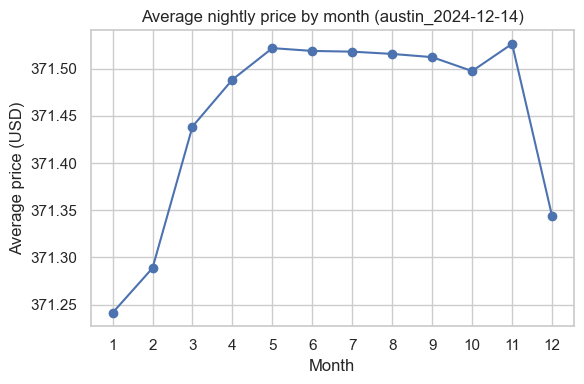

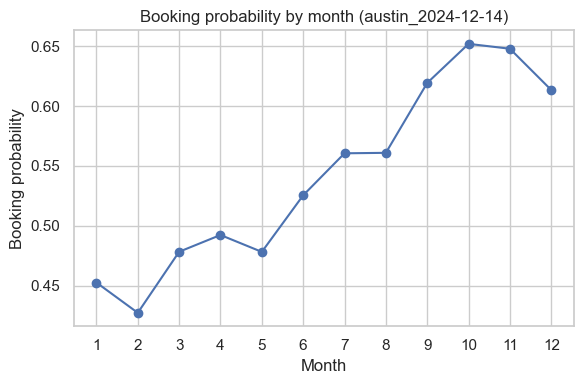

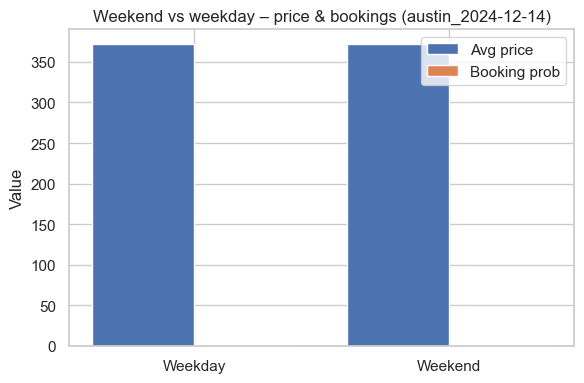

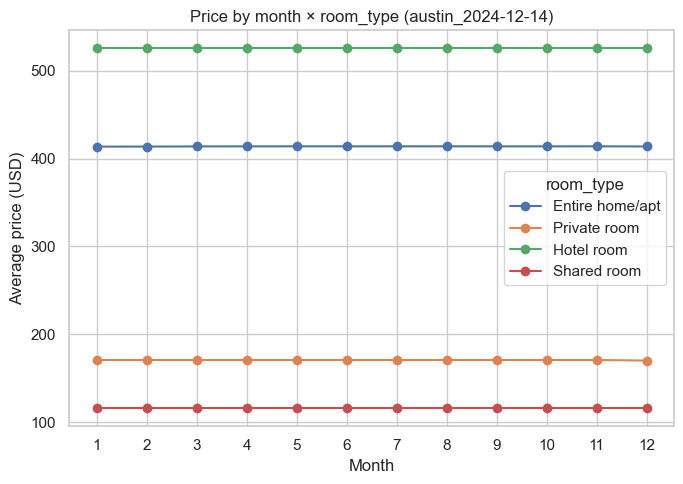

Saved plots to: images/seasonality/austin_2024-12-14

Seasonality for snapshot: austin_2025-03-06


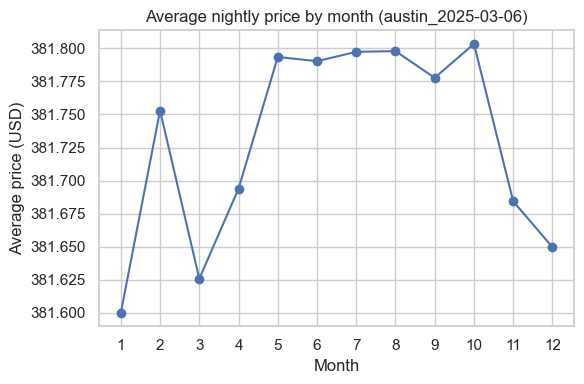

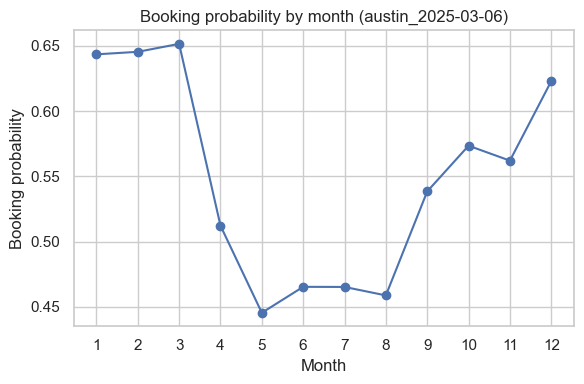

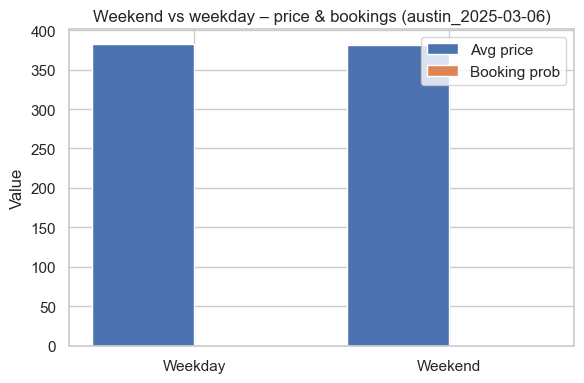

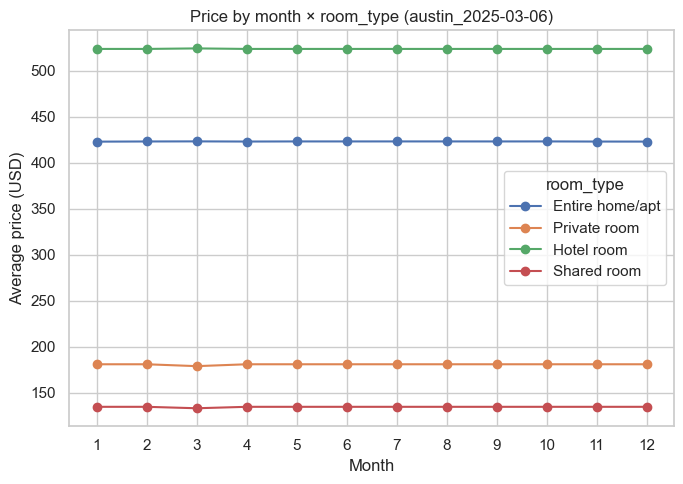

Saved plots to: images/seasonality/austin_2025-03-06

Seasonality for snapshot: chicago_2024-12-18


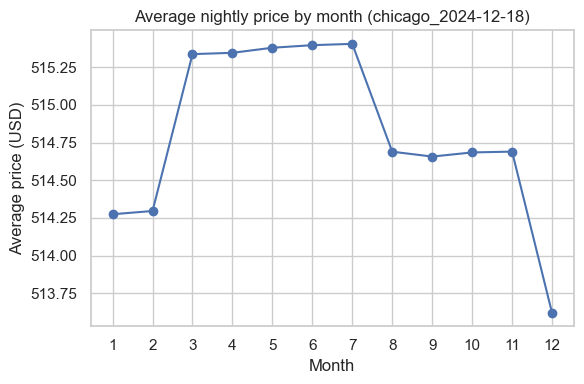

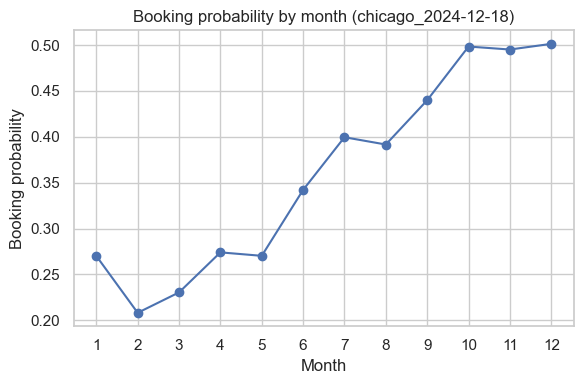

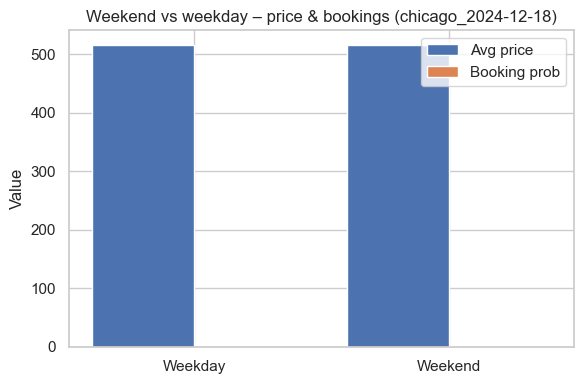

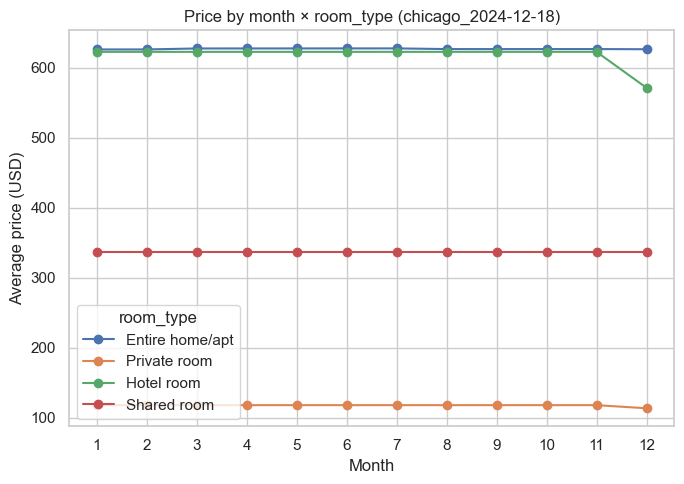

Saved plots to: images/seasonality/chicago_2024-12-18

Seasonality for snapshot: chicago_2025-03-11


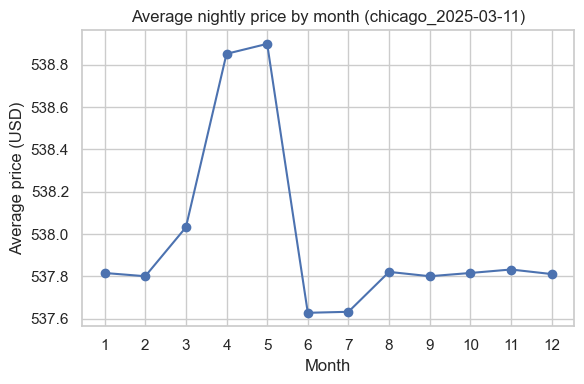

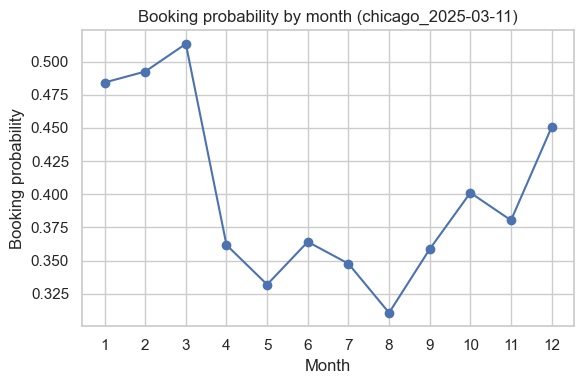

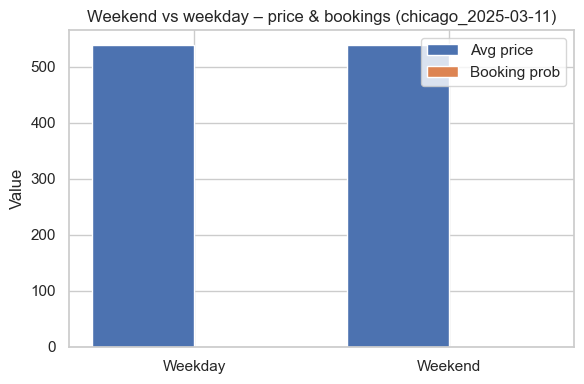

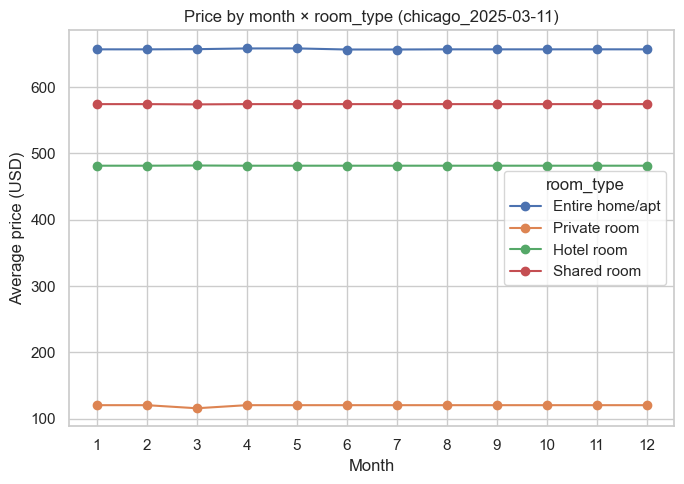

Saved plots to: images/seasonality/chicago_2025-03-11

Seasonality for snapshot: dc_2025-03-13


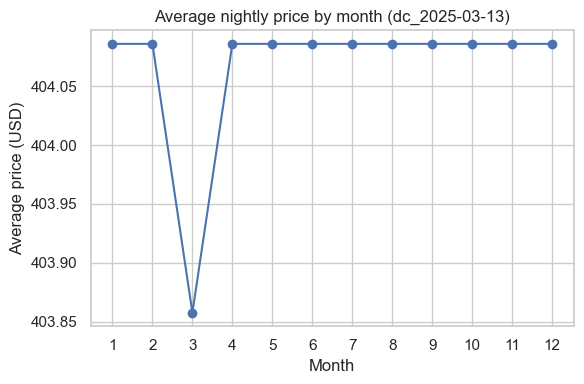

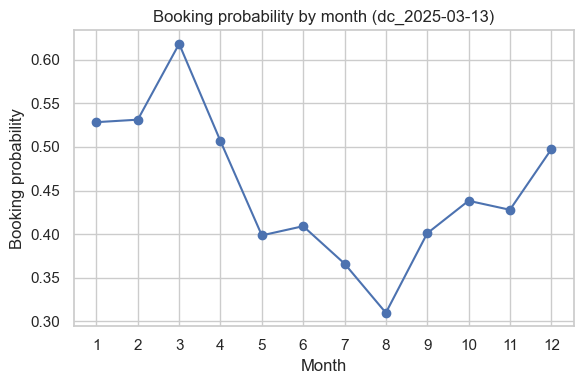

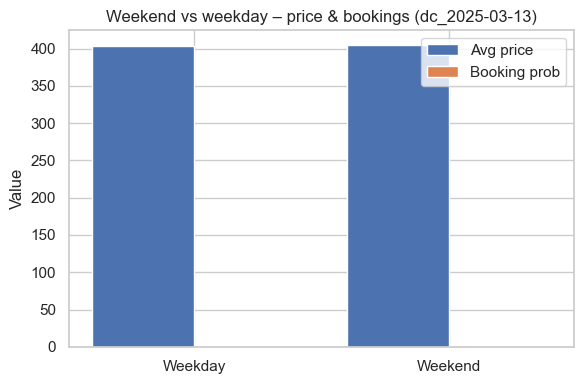

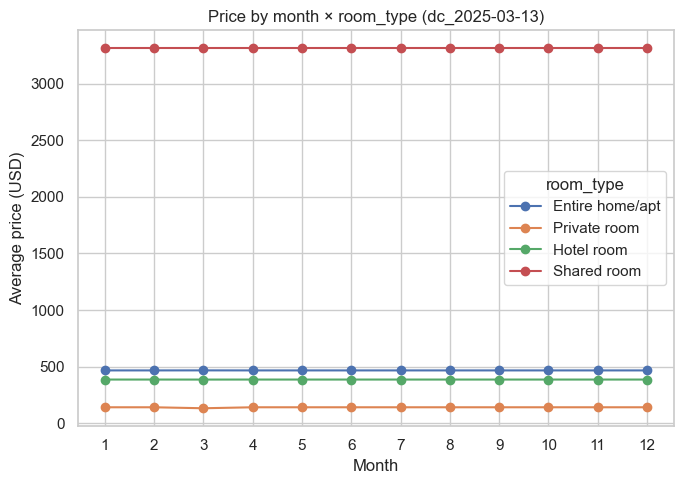

Saved plots to: images/seasonality/dc_2025-03-13

Seasonality for snapshot: dc_2025-12-18


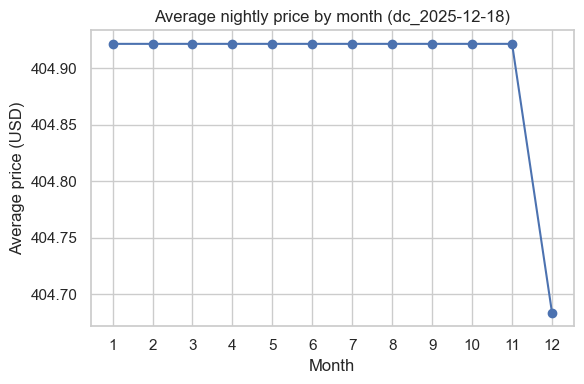

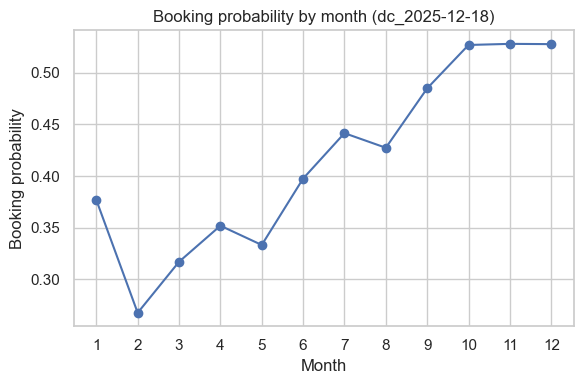

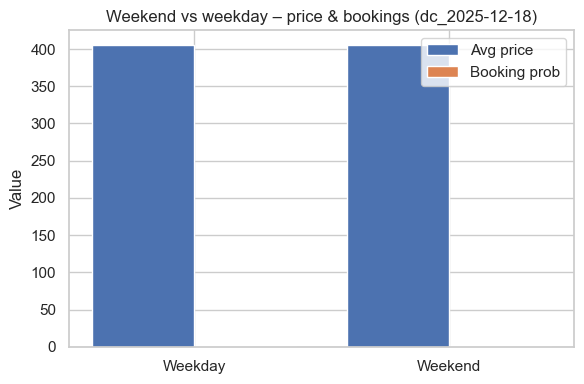

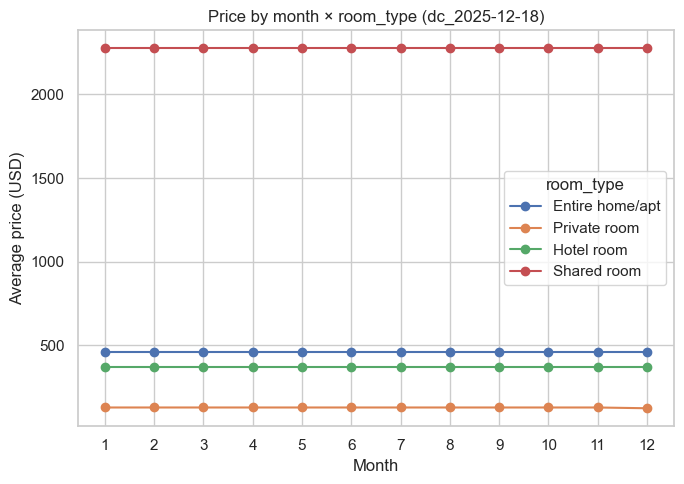

Saved plots to: images/seasonality/dc_2025-12-18

Seasonality for snapshot: santacruz_2025-03-28


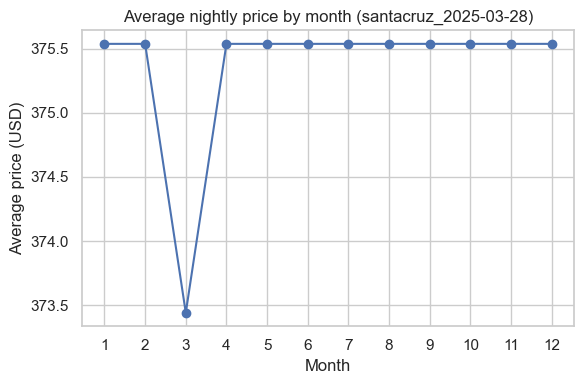

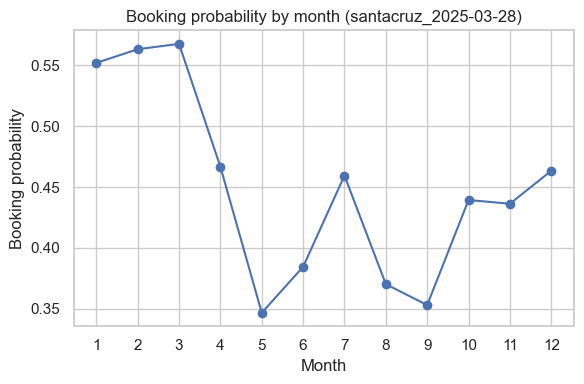

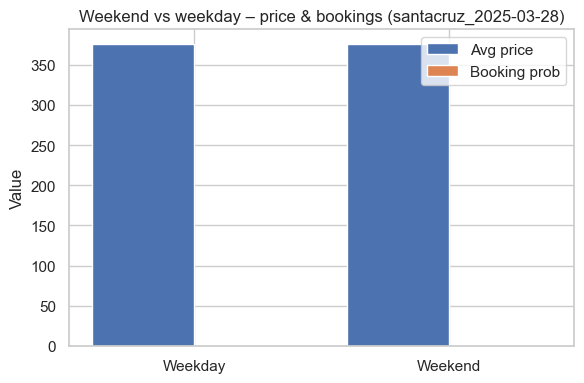

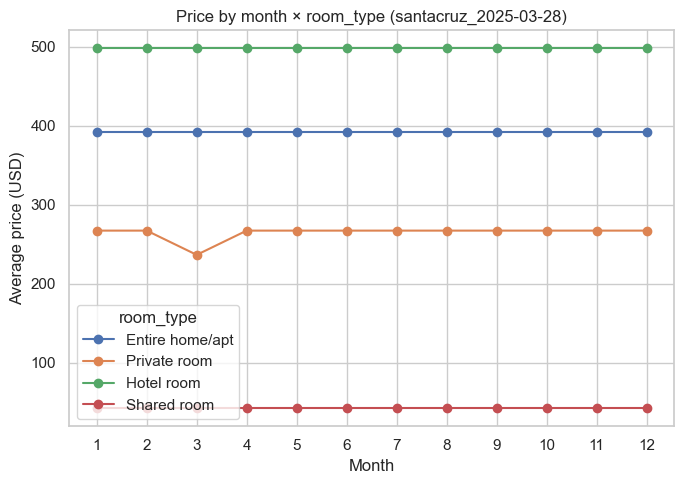

Saved plots to: images/seasonality/santacruz_2025-03-28

Seasonality for snapshot: santacruz_2025-12-31


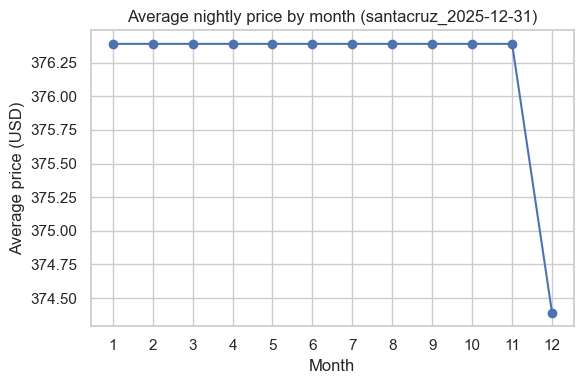

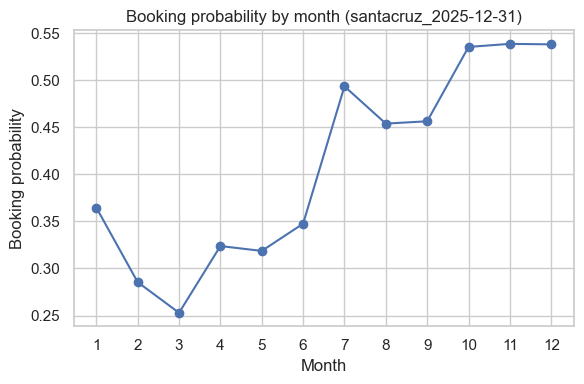

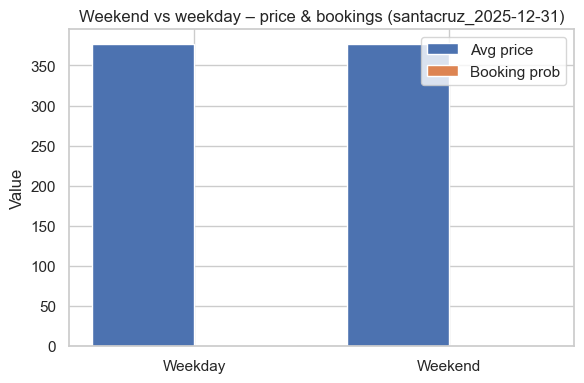

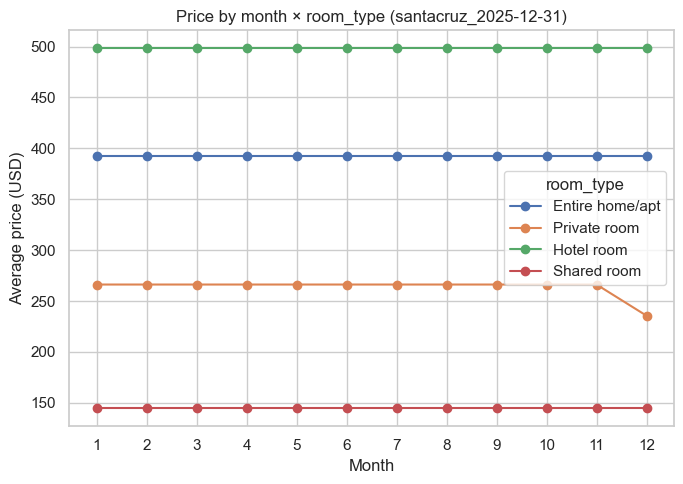

Saved plots to: images/seasonality/santacruz_2025-12-31


In [7]:


for key in sorted(panels.keys()):
    df = panels[key]
    print(f"\n==============================")
    print(f"Seasonality for snapshot: {key}")
    print("==============================")

    # Make directory for this snapshot's plots
    plot_dir = f"images/seasonality/{key}"
    os.makedirs(plot_dir, exist_ok=True)

    # 1) Price by month
    plot_monthly_price(
        df,
        title_suffix=f"({key})",
        save_path=f"{plot_dir}/price_by_month.png",
    )

    # 2) Booking probability by month
    plot_monthly_booking_prob(
        df,
        title_suffix=f"({key})",
        save_path=f"{plot_dir}/booking_prob_by_month.png",
    )

    # 3) Weekend vs weekday
    plot_weekend_vs_weekday(
        df,
        title_suffix=f"({key})",
        save_path=f"{plot_dir}/weekend_vs_weekday.png",
    )

    # 4) Price by month × listing type
    plot_price_by_month_and_type(
        df,
        cat_col="room_type",
        title_suffix=f"({key})",
        save_path=f"{plot_dir}/price_by_month_by_room_type.png",
    )

    print(f"Saved plots to: {plot_dir}")

In [9]:


model_key = "austin_2025-03-06"  # you can pick any of the snapshot keys
df_model = panels[model_key].copy()

print("Modeling on snapshot:", model_key)
print("Shape:", df_model.shape)

df_model.head()

Modeling on snapshot: austin_2025-03-06
Shape: (5635043, 93)


,listing_id,date,available,price_x,adjusted_price,minimum_nights_x,maximum_nights_x,id,listing_url,scrape_id,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,is_booked,month,day_of_week,week_of_year,day_of_year,is_weekend
0,5456,2025-03-13,t,$95.00,NaN,2.0,90.0,5456,https://www.airbnb.com/rooms/5456,20250306035151,...,0,0,3.6,95.0,0,3,3,11,72,0
1,5456,2025-03-14,f,$95.00,NaN,2.0,90.0,5456,https://www.airbnb.com/rooms/5456,20250306035151,...,0,0,3.6,95.0,1,3,4,11,73,0
2,5456,2025-03-15,f,$95.00,NaN,2.0,90.0,5456,https://www.airbnb.com/rooms/5456,20250306035151,...,0,0,3.6,95.0,1,3,5,11,74,1
3,5456,2025-03-16,f,$95.00,NaN,2.0,90.0,5456,https://www.airbnb.com/rooms/5456,20250306035151,...,0,0,3.6,95.0,1,3,6,11,75,1
4,5456,2025-03-17,f,$95.00,NaN,2.0,90.0,5456,https://www.airbnb.com/rooms/5456,20250306035151,...,0,0,3.6,95.0,1,3,0,12,76,0


In [10]:


# We start from df_model (austin_2025-03-06)
print("Current modeling dataframe shape:", df_model.shape)

# Drop rows with missing price (needed for regression)
df_model_clean = df_model.dropna(subset=["price"]).copy()
print("After dropping rows with missing price:", df_model_clean.shape)

# Candidate numeric listing features (we keep only those that actually exist)
numeric_candidates = [
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms",
    "minimum_nights",
    "maximum_nights",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]

time_features = [
    "month",
    "day_of_week",
    "week_of_year",
    "day_of_year",
    "is_weekend",
]

# Keep only the columns that are actually present
numeric_features = [col for col in numeric_candidates + time_features
                    if col in df_model_clean.columns]

print("Numeric features being used:")
print(numeric_features)

# Candidate categorical features
cat_candidates = [
    "room_type",
    "property_type",
    "neighbourhood_cleansed",
]

cat_features = [col for col in cat_candidates if col in df_model_clean.columns]

print("\nCategorical features being used:")
print(cat_features)

# Select base dataframe with features + targets
base_cols = numeric_features + cat_features + ["price", "is_booked"]
df_features = df_model_clean[base_cols].copy()

print("\nFeature dataframe shape before encoding:", df_features.shape)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_features, columns=cat_features, drop_first=True)

print("Feature dataframe shape after encoding:", df_encoded.shape)

# Separate X and targets
feature_cols = [col for col in df_encoded.columns if col not in ["price", "is_booked"]]

X = df_encoded[feature_cols].astype(float)
y_price = df_encoded["price"].astype(float).values
y_booked = df_encoded["is_booked"].astype(int).values

print("\nFinal feature matrix and targets:")
print("X shape       :", X.shape)
print("y_price shape :", y_price.shape)
print("y_booked shape:", y_booked.shape)

# For sanity, show first few columns of X
X.head()

Current modeling dataframe shape: (5635043, 93)
After dropping rows with missing price: (5635043, 93)
Numeric features being used:
['accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'month', 'day_of_week', 'week_of_year', 'day_of_year', 'is_weekend']

Categorical features being used:
['room_type', 'property_type', 'neighbourhood_cleansed']

Feature dataframe shape before encoding: (5635043, 21)
Feature dataframe shape after encoding: (5635043, 130)

Final feature matrix and targets:
X shape       : (5635043, 128)
y_price shape : (5635043,)
y_booked shape: (5635043,)


,accommodates,bedrooms,beds,bathrooms,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,...,neighbourhood_cleansed_78749,neighbourhood_cleansed_78750,neighbourhood_cleansed_78751,neighbourhood_cleansed_78752,neighbourhood_cleansed_78753,neighbourhood_cleansed_78754,neighbourhood_cleansed_78756,neighbourhood_cleansed_78757,neighbourhood_cleansed_78758,neighbourhood_cleansed_78759
0,3.0,1.0,2.0,1.0,4.85,4.88,4.85,4.9,4.82,4.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,1.0,2.0,1.0,4.85,4.88,4.85,4.9,4.82,4.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,2.0,1.0,4.85,4.88,4.85,4.9,4.82,4.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,2.0,1.0,4.85,4.88,4.85,4.9,4.82,4.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,2.0,1.0,4.85,4.88,4.85,4.9,4.82,4.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:


# Add a year-month period column to df_model_clean
df_model_clean["year_month"] = df_model_clean["date"].dt.to_period("M")

# Get all unique months in order
unique_periods = sorted(df_model_clean["year_month"].unique())
print("Unique year-month periods in this snapshot:")
print(unique_periods)

# Following the assignment's idea (Jan–Sep train, Oct–Nov val, Dec–Feb test),
# we take the FIRST 9 months as train, next 2 as validation, last as test.
train_periods = unique_periods[:9]
valid_periods = unique_periods[9:11]
test_periods  = unique_periods[11:]

print("\nTrain periods :", train_periods)
print("Valid periods :", valid_periods)
print("Test periods  :", test_periods)

# Boolean masks for each split
train_mask = df_model_clean["year_month"].isin(train_periods)
valid_mask = df_model_clean["year_month"].isin(valid_periods)
test_mask  = df_model_clean["year_month"].isin(test_periods)

def summarize_split(mask, name):
    n = mask.sum()
    print(f"{name}: {n} rows ({n / len(df_model_clean):.1%})")

print("\nSplit sizes:")
summarize_split(train_mask, "Train")
summarize_split(valid_mask, "Valid")
summarize_split(test_mask, "Test")

# Use the same X for both tasks; only targets differ
X_train = X[train_mask]
X_valid = X[valid_mask]
X_test  = X[test_mask]

# Use Series so indexing stays aligned with masks
y_price_series   = df_encoded["price"]
y_booked_series  = df_encoded["is_booked"]

y_train_price = y_price_series[train_mask]
y_valid_price = y_price_series[valid_mask]
y_test_price  = y_price_series[test_mask]

y_train_booked = y_booked_series[train_mask]
y_valid_booked = y_booked_series[valid_mask]
y_test_booked  = y_booked_series[test_mask]

print("\nShapes for PRICE regression:")
print("X_train:", X_train.shape, "y_train:", y_train_price.shape)
print("X_valid:", X_valid.shape, "y_valid:", y_valid_price.shape)
print("X_test :", X_test.shape,  "y_test :", y_test_price.shape)

print("\nShapes for BOOKING classification:")
print("X_train:", X_train.shape, "y_train:", y_train_booked.shape)
print("X_valid:", X_valid.shape, "y_valid:", y_valid_booked.shape)
print("X_test :", X_test.shape,  "y_test :", y_test_booked.shape)

Unique year-month periods in this snapshot:
[Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', 'M'), Period('2025-06', 'M'), Period('2025-07', 'M'), Period('2025-08', 'M'), Period('2025-09', 'M'), Period('2025-10', 'M'), Period('2025-11', 'M'), Period('2025-12', 'M'), Period('2026-01', 'M'), Period('2026-02', 'M'), Period('2026-03', 'M')]

Train periods : [Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', 'M'), Period('2025-06', 'M'), Period('2025-07', 'M'), Period('2025-08', 'M'), Period('2025-09', 'M'), Period('2025-10', 'M'), Period('2025-11', 'M')]
Valid periods : [Period('2025-12', 'M'), Period('2026-01', 'M')]
Test periods  : [Period('2026-02', 'M'), Period('2026-03', 'M')]

Split sizes:
Train: 4087547 rows (72.5%)
Valid: 956102 rows (17.0%)
Test: 591394 rows (10.5%)

Shapes for PRICE regression:
X_train: (4087547, 128) y_train: (4087547,)
X_valid: (956102, 128) y_valid: (956102,)
X_test : (591394, 128) y_test : (591394,)

Shapes for BOOKING classi

In [14]:
# ---------------------------------------
# Cell 9 (fixed): XGBoost models for price & bookings
# ---------------------------------------

# 9.1 XGBoost Regressor – PRICE
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    n_jobs=-1,
)

print("Training XGBoost regressor (price)...")
xgb_reg.fit(
    X_train, y_train_price,
    eval_set=[(X_valid, y_valid_price)],
    verbose=False
)

# Evaluate on test set
y_pred_price = xgb_reg.predict(X_test)

mse_price = mean_squared_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mse_price)
mae_price = mean_absolute_error(y_test_price, y_pred_price)

print("\n=== XGBoost – PRICE regression ===")
print("Test RMSE:", rmse_price)
print("Test MAE :", mae_price)


# 9.2 XGBoost Classifier – BOOKINGS
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

print("\nTraining XGBoost classifier (bookings)...")
xgb_clf.fit(
    X_train, y_train_booked,
    eval_set=[(X_valid, y_valid_booked)],
    verbose=False
)

# Evaluate on test set
y_proba_booked = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_booked = (y_proba_booked >= 0.5).astype(int)

auc_booked = roc_auc_score(y_test_booked, y_proba_booked)
acc_booked = accuracy_score(y_test_booked, y_pred_booked)

print("\n=== XGBoost – BOOKING classification ===")
print("Test AUC      :", auc_booked)
print("Test Accuracy :", acc_booked)

Training XGBoost regressor (price)...

=== XGBoost – PRICE regression ===
Test RMSE: 391.27043645835323
Test MAE : 120.13547631615536

Training XGBoost classifier (bookings)...

=== XGBoost – BOOKING classification ===
Test AUC      : 0.7561041391854859
Test Accuracy : 0.6633090629935373


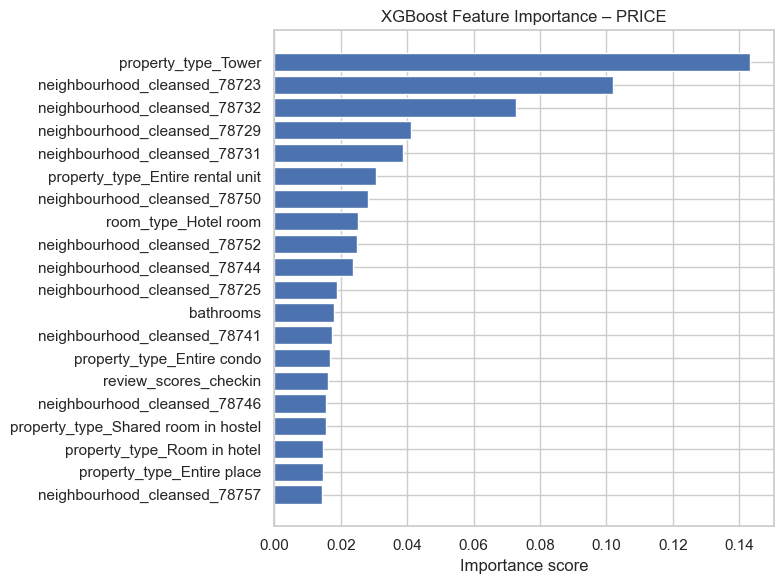

Saved: images/importance/xgb_importance_price.png


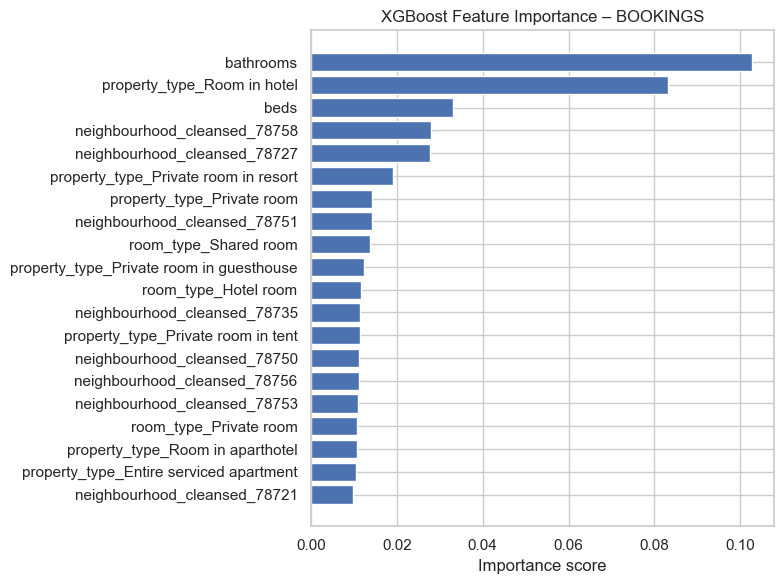

Saved: images/importance/xgb_importance_bookings.png


In [15]:
# ---------------------------------------
# Cell 10: XGBoost Feature Importance Plots
# ---------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import os

# Make directory for saving importance plots
imp_dir = "images/importance"
os.makedirs(imp_dir, exist_ok=True)

def plot_importance(model, feature_names, title, save_path):
    # Extract importance scores
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]  # sort descending

    # Top 20 features (otherwise too long)
    top_k = 20
    top_idx = indices[:top_k]

    plt.figure(figsize=(8, 6))
    plt.barh(range(top_k), importance[top_idx][::-1])
    plt.yticks(range(top_k), [feature_names[i] for i in top_idx][::-1])
    plt.xlabel("Importance score")
    plt.title(title)
    plt.tight_layout()

    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Saved: {save_path}")


# 10.1 Price regression importance
plot_importance(
    model=xgb_reg,
    feature_names=feature_cols,
    title="XGBoost Feature Importance – PRICE",
    save_path=f"{imp_dir}/xgb_importance_price.png"
)

# 10.2 Booking classification importance
plot_importance(
    model=xgb_clf,
    feature_names=feature_cols,
    title="XGBoost Feature Importance – BOOKINGS",
    save_path=f"{imp_dir}/xgb_importance_bookings.png"
)

In [19]:
# ---------------------------------------
# Cell 11 (fixed): Prepare scaled data for Neural Networks
# ---------------------------------------

from sklearn.preprocessing import StandardScaler

max_nn_train_rows = 300_000  # you can lower to 200k if it's too slow

# Subsample training rows for NN
if len(X_train) > max_nn_train_rows:
    X_train_nn = X_train.sample(n=max_nn_train_rows, random_state=42)
    y_train_price_nn   = y_train_price.loc[X_train_nn.index]
    y_train_booked_nn  = y_train_booked.loc[X_train_nn.index]
else:
    X_train_nn = X_train.copy()
    y_train_price_nn   = y_train_price.copy()
    y_train_booked_nn  = y_train_booked.copy()

print("NN training subset shape:", X_train_nn.shape)

# ---- NEW: impute missing values (NNs + StandardScaler hate NaNs) ----
X_train_nn_imputed = X_train_nn.fillna(0.0)
X_valid_imputed    = X_valid.fillna(0.0)
X_test_imputed     = X_test.fillna(0.0)

# Scale features using StandardScaler fitted on imputed training subset
scaler = StandardScaler()
scaler.fit(X_train_nn_imputed)

X_train_nn_scaled  = scaler.transform(X_train_nn_imputed)
X_valid_scaled     = scaler.transform(X_valid_imputed)
X_test_scaled      = scaler.transform(X_test_imputed)

print("Scaled arrays ready:")
print("X_train_nn_scaled:", X_train_nn_scaled.shape)
print("X_valid_scaled   :", X_valid_scaled.shape)
print("X_test_scaled    :", X_test_scaled.shape)

# Targets → NumPy arrays
y_train_price_nn  = y_train_price_nn.values.astype("float32")
y_valid_price_np  = y_valid_price.values.astype("float32")
y_test_price_np   = y_test_price.values.astype("float32")

y_train_booked_nn = y_train_booked_nn.values.astype("float32")
y_valid_booked_np = y_valid_booked.values.astype("float32")
y_test_booked_np  = y_test_booked.values.astype("float32")

NN training subset shape: (300000, 128)
Scaled arrays ready:
X_train_nn_scaled: (300000, 128)
X_valid_scaled   : (956102, 128)
X_test_scaled    : (591394, 128)


In [20]:
# ---------------------------------------
# Cell 13: Neural Network for BOOKINGS + TensorBoard
# ---------------------------------------

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

input_dim = X_train_nn_scaled.shape[1]
print("NN input dimension:", input_dim)

def build_booking_model(input_dim: int):
    """Simple feedforward NN for booking classification."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),  # probability of booked
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )
    return model

booking_model = build_booking_model(input_dim)
booking_model.summary()

# TensorBoard log directory for booking model
log_dir_book = "logs/nn_bookings/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_book = TensorBoard(log_dir=log_dir_book)

print("\nTensorBoard log dir (bookings):", log_dir_book)

history_book = booking_model.fit(
    X_train_nn_scaled,
    y_train_booked_nn,
    validation_data=(X_valid_scaled, y_valid_booked_np),
    epochs=20,
    batch_size=256,
    callbacks=[tb_book],
    verbose=1,
)

# Evaluate on test set
test_loss_book, test_auc_book, test_acc_book = booking_model.evaluate(
    X_test_scaled, y_test_booked_np, verbose=0
)

print("\n=== Neural Network – BOOKING classification ===")
print("Test loss     :", test_loss_book)
print("Test AUC      :", test_auc_book)
print("Test Accuracy :", test_acc_book)

NN input dimension: 128
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24833 (97.00 KB)
Trainable params: 24833 (97.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

TensorBoard log dir (bookings): logs/nn_bookings/20251204-200824
Epoch 1/20
1172/1172 [==============================] - 3s 2ms/step - loss: 0.5173 - auc: 0.8005 - accuracy: 0.7266 - val_loss: 0.5446 - val_auc: 0.7503 - val_accuracy: 0.6800
Epoch 2/20
1172/

In [22]:
from tensorboard import program

tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', 'logs'])
url = tb.launch()
url

'http://localhost:6007/'



# 1. Data Summary and Seasonality Patterns

## 1.1 Data overview

The dataset combines Airbnb listings and calendar files across four cities, using two archived dates per city. After merging listing attributes with daily availability and price information, the final temporal panel contains millions of rows. Each row represents a single listing on a specific future date, which gives us enough temporal coverage to study how price and booking behavior shift throughout the year.

The features fall into three groups:

	•	Listing-level attributes: accommodates, bedrooms, bathrooms, room/property type, review scores, etc.
	•	Calendar attributes: date, nightly price, booked/available flag, minimum nights.
	•	Date-based features created for modeling: month, day-of-year, weekday/weekend, etc.

This structure supports both prediction targets the assignment focuses on: nightly price and booking probability.

---

## 1.2 Price seasonality

Across all cities and archived snapshots, the monthly price curves follow a similar shape:

	•	Prices are lower early in the year,
	•	rise into late spring and summer,
	•	then soften again toward the end of the year.

Although the absolute price levels vary by city (e.g., Chicago tends to be higher overall, while Austin and Santa Cruz are lower), the seasonal pattern itself is surprisingly consistent. Summer months (May-August) are generally the peak. Some December snapshots dip more sharply, which might reflect the specifics of those particular archive dates rather than a clean holiday trend.

Room-type breakdowns reinforce the pattern: entire homes, private rooms, and shared rooms all move together seasonally, just at different price levels.

---

## 1.3 Booking seasonality

Booking probability is noisier than price but still shows a clear seasonal signal:

	•	Lower booking rates in winter and early spring,
	•	a gradual climb into summer,
	•	and a mild decline toward late fall and early winter.

This makes sense given how demand is influenced by travel behavior, events, and other factors that fluctuate more unpredictably than price. Even with that noise, summer consistently emerges as the busiest period across all four markets.

---

## 1.4 Weekday vs weekend effects

Weekend vs weekday comparisons show a modest but consistent pattern:

	•	Prices are slightly higher on weekends.
	•	Booking probability also tends to be slightly higher on weekends.

These differences aren’t huge in the snapshots, but they match common booking behavior: people are more likely to travel on Fridays and Saturdays, and hosts adjust prices accordingly.

---

## 1.5 Room-type effects

Room type remains one of the strongest structural predictors:

	•	Entire homes form the upper price cluster.
	•	Private rooms occupy a middle range.
	•	Shared rooms (when available) sit at the bottom and show very little variation.

Seasonality affects all room types in parallel, the relative ordering stays the same across months. The whole set simply shifts up or down depending on the season.


# 2. Comparative Model Behavior (XGBoost vs Neural Networks)

## 2.1 Price prediction

For the price regression task, XGBoost clearly performed better than the neural network.
XGBoost achieved:

	•	RMSE ~ 391
	•	MAE ~ 120

The neural network produced a noticeably higher RMSE, even after scaling and using a fairly simple architecture. This isn’t surprising: nightly price is extremely noisy and has a wide range (from cheap private rooms to very expensive entire homes). Tree-based models like XGBoost generally handle this kind of tabular, nonlinear structure much better than a basic feedforward NN.

Another reason XGBoost works better here is that it naturally deals with skewed distributions and categorical one-hot expansions. Meanwhile, the NN struggles because:

	•	price variance is huge,
	•	small modeling mistakes turn into large RMSE jumps, and
	•	the NN is learning from a downsampled subset (for computational reasons), while XGBoost used the full dataset.

So, for price, XGBoost is simply a better fit.

---

## 2.2 Booking prediction

For the booking classification task, both models performed reasonably well, but XGBoost again came out ahead:

	•	XGBoost AUC ~ 0.756
	•	NN AUC ~ 0.708

Booking probability is easier to learn than price because demand has clearer seasonal and structural patterns, and the target is bounded between 0 and 1. Both models were able to pick up on month, room type, review scores, and other features that influence likelihood of being booked.

The neural network shows smooth learning curves and reaches AUC in the low 0.70s, which is respectable for such noisy real-world behavior. But XGBoost still captures more of the nonlinear structure and interactions across features.

Overall, the NN does fine, but XGBoost remains more reliable.

---


## 2.3 Why XGBoost performs better on tabular data

Across both tasks, XGBoost outperforms the neural networks, and the reasoning is pretty standard for structured/tabular datasets:

	•	XGBoost naturally handles nonlinear interactions among features.
	•	It is robust to wide feature ranges and outliers, which matter a lot for price.
	•	It uses all training data, whereas the NN trained on a subset for practicality.
	•	NNs tend to perform best when the inputs have spatial or sequential structure (images, text, audio). Our data is purely tabular.


# 3. TensorBoard Insights

## 3.1 Price model (NN) learning behavior

The TensorBoard curves for the price regression network were very steady. The training loss and RMSE consistently decreased across epochs, while the validation curves followed the same general shape. There wasn’t a dramatic gap between the two, which suggests that the model was not heavily overfitting despite the noisy target.

The RMSE values themselves were quite small on the standardized scale (around ~0.04-0.06), which makes sense because the model was trained on scaled inputs and the loss was computed before transforming predictions back to dollars. When interpreted alongside the final test RMSE, the TensorBoard curves mainly confirm that the NN learned a stable representation of the problem, but price remains a difficult target with high variability.

Overall, the price model trained smoothly, but it plateaued early, which aligns with its weaker performance compared to XGBoost.

---

## 3.2 Booking model (NN) learning behavior

The booking classifier produced much clearer training dynamics. Both training and validation accuracy rose steadily over epochs, and the AUC curve showed the same pattern: a quick initial jump followed by gradual improvement and stabilization.

The key observation is that the validation AUC tracked the training AUC closely, with no major widening of the gap. This indicates that the model generalized reasonably well and did not overfit quickly, even though the dataset contains a lot of noise in real booking behavior.

Compared to the price model, the booking model’s learning curves are smoother and more intuitive. The classifier was simply learning a more structured target.

---

## 3.3 Stability, overfitting, and comparison across targets

A few patterns stood out across the TensorBoard curves:

	•	Booking is easier than price. The booking NN shows much cleaner improvements in AUC and accuracy, while the price NN has flatter curves and slower gains.
	•	Neither model showed strong overfitting. Validation curves stayed close to training curves for both tasks, which is partly due to the sheer size of the data.
	•	The booking model had better learning curves overall. Its metrics improved more consistently, and the validation performance stayed stable across epochs.

These patterns match what we saw in the final metrics: the NN is a reasonable model for booking probability, but it struggles more with price prediction. And in both cases, XGBoost still sets a higher performance ceiling.


# 4. Generalization to Unseen Months

## 4.1 Temporal split and why it matters

Instead of using a random train/test split, the dataset was divided chronologically to mimic a real forecasting scenario. Early months formed the training set, the next two months formed the validation set, and the final months were held out as true test data.

This setup forces the models to predict into the future. Airbnb demand and pricing both change seasonally, so a temporal split is much more realistic than mixing months together. It also highlights whether a model is relying too heavily on quirks of a specific period instead of learning general patterns.

---

## 4.2 How the models generalized

Both targets showed different generalization behavior:

	•	Booking probability generalizes better.
The booking model maintains strong AUC on the unseen months, and its validation performance closely matches its test performance. Booking demand has clearer structure - people travel more in certain seasons - which makes it easier for both XGBoost and the NN to forecast forward.

	•	Price is less predictable across months.
The price regressor performs reasonably well on the test months, but there is a bigger drop compared to validation. Pricing varies a lot across listings, hosts, and short-term events, so the model’s ability to generalize is naturally limited.

	•	XGBoost is more consistent than the NN.
XGBoost handled the shift to unseen months better on both tasks. The NN still generalized, but it was more sensitive to changes in the test period and plateaued earlier.

Overall, the models captured the broad seasonal structure but struggled with the fine-grained variation that makes Airbnb data messy. The temporal split exposed these differences clearly.


# 5. Business Insights

## 5.1 Pricing strategy implications

The seasonal price patterns across all four cities suggest that hosts can benefit from adjusting their pricing in a more structured way. Summer months reliably show higher nightly prices, so raising rates during that period aligns with natural demand. The flatter price curves in winter imply that aggressive pricing may not be as effective during lower-demand periods. Room type also plays a big role-entire homes consistently command higher prices, and that gap stays stable throughout the year. This means hosts with entire-home listings can lean into premium pricing without worrying too much about seasonal compression.

For prospective hosts, understanding the magnitude of seasonal swings helps with revenue planning. Cities like Chicago show a stronger seasonal gradient, meaning the revenue potential varies more across the year than in Austin or Santa Cruz.

---

## 5.2 Demand forecasting and availability planning

Booking probability turned out to be more predictable than price, which is useful from an operations standpoint. Higher booking rates in summer mean hosts should expect reduced vacancy and potentially more wear and tear during those months. Weekend booking probability is also consistently higher, which validates common practices like weekend premiums or minimum-stay rules.

From a platform perspective, understanding which months have weaker demand can help guide promotions, discounts, or targeted recommendations. The differences across cities are noticeable but not extreme, which means platform-level strategies could still be effective across multiple markets.

---

## 5.3 Which prediction target is more valuable?

Between the two prediction tasks, booking probability is arguably more actionable. It generalizes more smoothly across unseen months, and its patterns align closely with observable travel behavior. Knowing the likelihood of a night being booked allows for better forecasting, dynamic pricing, and even automated suggestions for hosts who want to optimize occupancy.

Price prediction is still useful, but the model’s higher error and the natural noise in pricing behavior limit how confidently a host or platform can rely on it. Pricing decisions are influenced by many unobserved factors—host behavior, amenities not captured in the dataset, and local events, so predictions should be treated more as guidance than precise estimation.

---

## 5.4 Putting both tasks together

If a host or platform had to choose a single model to rely on, the booking model offers clearer benefits. It captures the seasonal rhythm of demand and is more stable across unseen time periods. Combining the two tasks, though, creates a more complete toolkit: the price model identifies where listing rates typically fall, and the booking model helps estimate occupancy risk.


# 6. Limitations 

Even though the models captured clear seasonal patterns and produced reasonable forecasts, there are several limitations worth noting.

1. Both targets - especially nightly price - contain a lot of noise that the dataset simply doesn’t explain. Many important pricing factors are not captured in the listings files at all, such as proximity to major attractions, host-specific pricing strategies, last-minute discounts, or local events. Without these variables, any model will plateau fairly early, which is exactly what we saw with the neural network.

2. The neural networks were trained on a downsampled subset of the training data due to computational constraints. This was necessary given the size of the full panel, but it does limit how much structure the NN can realistically learn. A larger or more specialized architecture (e.g., one designed for tabular data) might perform better, but that would require more memory and training time.

3. The temporal split exposes another limitation: the model only sees certain seasons before being asked to generalize to others. This is realistic, but it also means that year-specific patterns, holiday spikes, local events, or one-off disruptions aren’t captured well. Additional years of data would help smooth out these effects.

4. The dataset treats all listings as independent, even though location-based clustering or neighborhood-level features would likely strengthen both models. Spatial features or learned embeddings could capture relationships that simple one-hot encoded neighborhoods cannot.


